In [33]:
# ---------- GLOBAL STYLE ----------
# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern for math symbols
plt.rcParams['font.size'] = 12  # Base font size
plt.rcParams['axes.labelsize'] = 14  # Font size for axis labels
plt.rcParams['axes.titlesize'] = 14  # Font size for titles
plt.rcParams['xtick.labelsize'] = 12  # Font size for tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size for tick labels
plt.rcParams['legend.fontsize'] = 12  # Font size for legends
# Set default line width for all plots (change this value to adjust thickness)
plt.rcParams['lines.linewidth'] = 0.75

In [4]:
from __future__ import annotations 

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Optional, Tuple, Union, List

import numpy as np


@dataclass
class EMSASpectrum:
    header: Dict[str, str]
    x: Optional[np.ndarray]   # e.g., energy/channel axis if available
    y: np.ndarray             # counts/intensity


def _clean_key(line: str) -> str:
    # Example: "#XPERCHAN: 10" -> "XPERCHAN"
    line = line.strip()
    if line.startswith("#"):
        line = line[1:].lstrip()
    # Split at first ":" if present
    key = line.split(":", 1)[0].strip()
    return key.upper()


def _parse_header_line(line: str) -> Tuple[str, str]:
    # Example: "#DATE: 01-JAN-2020" -> ("DATE", "01-JAN-2020")
    line = line.strip()
    if line.startswith("#"):
        line = line[1:].lstrip()
    if ":" in line:
        k, v = line.split(":", 1)
        return k.strip().upper(), v.strip()
    # Some files may have "#KEY VALUE"
    parts = line.split(None, 1)
    if len(parts) == 2:
        return parts[0].strip().upper(), parts[1].strip()
    return parts[0].strip().upper(), ""


def read_emsa(path: Union[str, Path]) -> EMSASpectrum:
    """
    Read an EMSA/MSA (.EMSA / .MSA) spectrum file.

    Returns:
      EMSASpectrum(header=dict, x=array or None, y=array)

    Supports:
      - Header lines starting with '#'
      - Data after '#SPECTRUM' (common) or after '#DATA'/'#XYDATA' (variants)
      - Data as either:
          * one number per line (y only, x inferred from header if possible)
          * two numbers per line (x y pairs)
    """
    path = Path(path)
    text = path.read_text(errors="replace").splitlines()

    header: Dict[str, str] = {}
    data_lines: List[str] = []

    in_data = False

    for raw in text:
        line = raw.strip()
        if not line:
            continue

        if line.startswith("#"):
            key = _clean_key(line)

            # Common markers that indicate data begins after this line
            if key in {"SPECTRUM", "DATA", "XYDATA"}:
                in_data = True
                continue

            # Some files end header with "#END" or "#ENDOFDATA"
            if key in {"END", "ENDOFDATA"}:
                in_data = False
                continue

            # Normal header line
            k, v = _parse_header_line(line)
            header[k] = v
        else:
            if in_data:
                data_lines.append(line)
            # else: ignore stray non-# lines before data

    if not data_lines:
        raise ValueError(f"No spectrum data found in {path}. "
                         f"Expected a '#SPECTRUM'/'#DATA'/'#XYDATA' section.")

    # Parse numeric data. Allow whitespace and/or comma separated.
    rows: List[List[float]] = []
    for ln in data_lines:
        ln = ln.replace(",", " ")
        parts = [p for p in ln.split() if p]
        # Skip non-numeric junk safely
        try:
            nums = [float(p) for p in parts]
        except ValueError:
            continue
        if nums:
            rows.append(nums)

    if not rows:
        raise ValueError(f"Found data section but couldn't parse numeric values in {path}.")

    # Decide whether it's (x,y) pairs or y-only
    # If most rows have >=2 columns => treat as pairs, else single column.
    col_counts = [len(r) for r in rows]
    is_pairs = sum(c >= 2 for c in col_counts) > (len(col_counts) / 2)

    if is_pairs:
        arr = np.array([r[:2] for r in rows if len(r) >= 2], dtype=float)
        x = arr[:, 0]
        y = arr[:, 1]
    else:
        y = np.array([r[0] for r in rows if len(r) >= 1], dtype=float)

        # Try to infer x from common EMSA header fields
        # Some typical keys: NPOINTS, XPERCHAN, OFFSET, XUNITS, XORIGIN, etc.
        n = y.size

        x = None
        xperchan = None
        offset = None

        for k in ("XPERCHAN", "XPERCHANNEL", "X_STEP", "XDELTA"):
            if k in header:
                try:
                    xperchan = float(header[k])
                    break
                except ValueError:
                    pass

        for k in ("OFFSET", "XORIGIN", "X_OFFSET"):
            if k in header:
                try:
                    offset = float(header[k])
                    break
                except ValueError:
                    pass

        if xperchan is not None:
            if offset is None:
                offset = 0.0
            x = offset + xperchan * np.arange(n, dtype=float)

    return EMSASpectrum(header=header, x=x, y=y)


# Example usage:
if __name__ == "__main__":
    spec = read_emsa(r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\PALS\sem-annealed\SS316-2.25-3A\protB-3A-surf_001.EMSA")
    print("Header keys:", list(spec.header.keys())[:10], "...")
    print("y points:", spec.y.size)
    if spec.x is not None:
        print("x range:", spec.x.min(), "to", spec.x.max())


Header keys: ['FORMAT', 'VERSION', 'TITLE', 'DATE', 'TIME', 'OWNER', 'NPOINTS', 'NCOLUMNS', 'XUNITS', 'YUNITS'] ...
y points: 2048
x range: 0.0 to 20.47


In [34]:
import matplotlib.pyplot as plt

spec = read_emsa(r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\PALS\sem-annealed\SS316-2.25-3A\protB-3A-surf_001.EMSA")

plt.figure()
if spec.x is None:
    plt.plot(spec.y)
    plt.xlabel("Channel")
else:
    plt.plot(spec.x, spec.y)
    # If the file says what units x is in, you can show it:
    xunits = spec.header.get("XUNITS", "").strip()
    plt.xlabel(f"X ({xunits})" if xunits else "X")

yunits = spec.header.get("YUNITS", "").strip()
plt.ylabel(f"Intensity ({yunits})" if yunits else "Intensity")

title = spec.header.get("TITLE") or spec.header.get("SPECTRUM") or "EMSA Spectrum"
plt.title(title)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jeanv\\OneDrive - Delft University of Technology\\Uitwisseling - TUDelft\\Courses\\MEP\\Experiments\\PALS\\sem-annealed\\SS316-2.25-3A\\protB-3A-surf_001.EMSA'

Found these files (1–6):
1: 3A-001.EMSA
2: 3A-002.EMSA
3: 3A-003.EMSA
4: 3A-004.EMSA
5: 3A-005.EMSA
6: 3A-006.EMSA


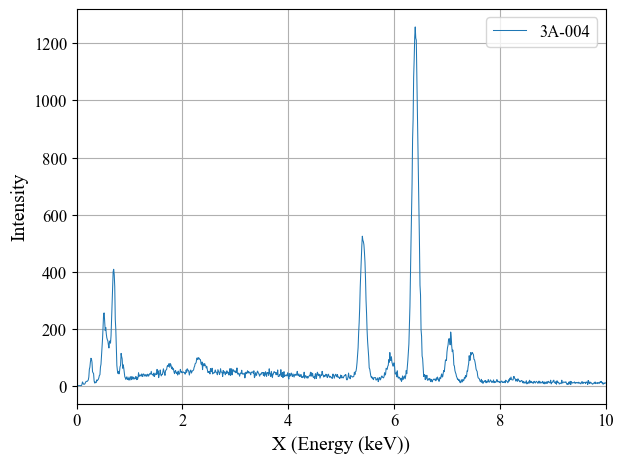

In [35]:
import re
from pathlib import Path
import matplotlib.pyplot as plt

# --- set your folder here ---
FOLDER = Path(r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\PALS\sem-annealed\SS316-2.25-3A")  # <-- change this

def parse_selection(sel: str, max_n: int) -> list[int]:
    """
    Accepts: 'all', '1,3,6', '2-5', '1, 2-4, 6'
    Returns 0-based indices.
    """
    sel = sel.strip().lower()
    if sel in {"all", "*"}:
        return list(range(max_n))

    out = set()
    tokens = re.split(r"[,\s]+", sel)
    for t in tokens:
        if not t:
            continue
        if "-" in t:
            a, b = t.split("-", 1)
            a, b = int(a), int(b)
            for i in range(min(a, b), max(a, b) + 1):
                if 1 <= i <= max_n:
                    out.add(i - 1)
        else:
            i = int(t)
            if 1 <= i <= max_n:
                out.add(i - 1)

    return sorted(out)

# --- find EMSA files (case-insensitive) ---
files = sorted([p for p in FOLDER.iterdir() if p.is_file() and p.suffix.lower() in {".emsa", ".msa"}])

if not files:
    raise FileNotFoundError(f"No .emsa/.msa files found in: {FOLDER}")

# take first 6 (as requested)
files = files[:6]

print("Found these files (1–{0}):".format(len(files)))
for i, fp in enumerate(files, start=1):
    print(f"{i}: {fp.name}")

selection = input("\nWhich spectra to plot? (e.g. all, 1,3, 2-4): ")
idxs = parse_selection(selection, max_n=len(files))

chosen = [files[i] for i in idxs]
if not chosen:
    raise ValueError("No valid selection. Try: all, or 1,3, or 2-4")

# --- plot them all on one figure ---
plt.figure()

for fp in chosen:
    spec = read_emsa(fp)
    label = spec.header.get("TITLE") or fp.stem

    if spec.x is None:
        plt.plot(spec.y, label=label)
        plt.xlabel("Channel")
    else:
        plt.plot(spec.x, spec.y, label=label)
        xunits = spec.header.get("XUNITS", "").strip()
        plt.xlabel(f"X ({xunits})" if xunits else "X")

plt.ylabel("Intensity")
plt.legend()
plt.xlim(0,10)
plt.grid(True)
plt.tight_layout()
plt.show()


Found these files (1–6):
1: 3A-001.EMSA
2: 3A-002.EMSA
3: 3A-003.EMSA
4: 3A-004.EMSA
5: 3A-005.EMSA
6: 3A-006.EMSA


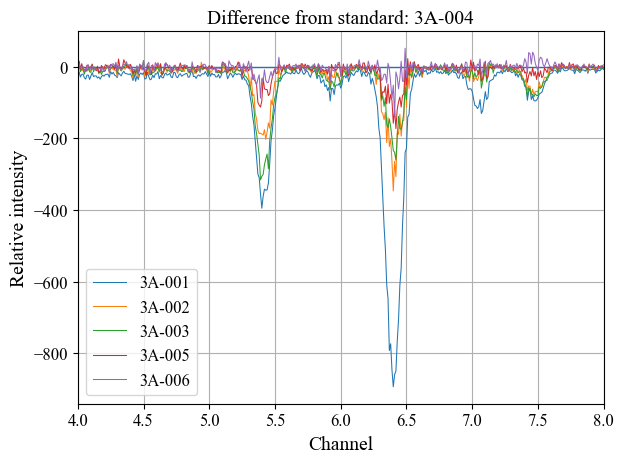

In [39]:
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --- set your folder here ---
FOLDER = Path(r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\PALS\sem-annealed\SS316-2.25-3A")  # <-- change this
  # <-- change this

def parse_selection(sel: str, max_n: int) -> list[int]:
    sel = sel.strip().lower()
    if sel in {"all", "*"}:
        return list(range(max_n))

    out = set()
    tokens = re.split(r"[,\s]+", sel)
    for t in tokens:
        if not t:
            continue
        if "-" in t:
            a, b = t.split("-", 1)
            a, b = int(a), int(b)
            for i in range(min(a, b), max(a, b) + 1):
                if 1 <= i <= max_n:
                    out.add(i - 1)
        else:
            i = int(t)
            if 1 <= i <= max_n:
                out.add(i - 1)
    return sorted(out)

def load_up_to_6(folder: Path):
    files = sorted([p for p in folder.iterdir()
                    if p.is_file() and p.suffix.lower() in {".emsa", ".msa"}])
    if not files:
        raise FileNotFoundError(f"No .emsa/.msa files found in: {folder}")
    return files[:6]

def interpolate_to(x_src, y_src, x_tgt):
    # Linear interpolation; values outside range become NaN
    return np.interp(x_tgt, x_src, y_src, left=np.nan, right=np.nan)

def parse_window(s: str):
    """
    Accepts:
      - "" (empty) -> no window (use all)
      - "0.5-8" -> numeric window
    Returns (low, high) as floats or (None, None)
    """
    s = s.strip()
    if not s:
        return None, None
    s = s.replace(" ", "")
    if "-" not in s:
        raise ValueError("Window must look like: 0.5-8  (low-high)")
    a, b = s.split("-", 1)
    low, high = float(a), float(b)
    if high < low:
        low, high = high, low
    return low, high

# --- main ---
files = load_up_to_6(FOLDER)

print("Found these files (1–{0}):".format(len(files)))
for i, fp in enumerate(files, start=1):
    print(f"{i}: {fp.name}")

std_i = int(input(f"\nWhich file is the STANDARD/background? (1-{len(files)}): ").strip()) - 1
if not (0 <= std_i < len(files)):
    raise ValueError("Standard index out of range.")

selection = input("Which spectra to subtract from the standard? (e.g. all, 2-6, 1,3): ")
idxs = parse_selection(selection, max_n=len(files))

# Optional: avoid subtracting standard from itself
idxs = [i for i in idxs if i != std_i]
if not idxs:
    raise ValueError("Nothing to plot after removing the standard from the selection.")

# Read standard
std_spec = read_emsa(files[std_i])
x_std = std_spec.x
y_std = std_spec.y.astype(float)

# Choose a window
if x_std is not None:
    xunits = std_spec.header.get("XUNITS", "").strip()
    w = input(f"Window on X axis (low-high, in {xunits or 'X units'}). Example: 0.5-8. Leave empty for all: ")
    wlow, whigh = parse_window(w)
else:
    w = input("Window on channels (low-high, e.g. 100-800). Leave empty for all: ")
    wlow, whigh = parse_window(w)


plt.figure()
plt.axhline(0, linewidth=1)

for i in idxs:
    spec = read_emsa(files[i])

    std_name = std_spec.header.get("TITLE") or files[std_i].stem
    this_name = spec.header.get("TITLE") or files[i].stem
    label = f"{this_name}"

    if x_std is not None and spec.x is not None:
        # Align to standard x grid
        x = x_std.astype(float)
        y = interpolate_to(spec.x.astype(float), spec.y.astype(float), x)
        ys = y_std.copy()

        # Keep overlap region
        m = ~np.isnan(y)
        x, y, ys = x[m], y[m], ys[m]

        # Apply window if requested
        if wlow is not None and whigh is not None:
            mw = (x >= wlow) & (x <= whigh)
            x, y, ys = x[mw], y[mw], ys[mw]

        diff = (y - ys)  # relative difference in %
        plt.plot(x, diff, label=label)
        plt.xlabel(f"X ({xunits})" if xunits else "X")

    else:
        # Channel-based subtraction
        n = min(len(y_std), len(spec.y))
        y = spec.y[:n].astype(float)
        ys = y_std[:n].astype(float)
        ch = np.arange(n)

        # Apply channel window if requested
        if wlow is not None and whigh is not None:
            low_i = max(0, int(np.floor(wlow)))
            high_i = min(n - 1, int(np.ceil(whigh)))
            ch = ch[low_i:high_i + 1]
            y = y[low_i:high_i + 1]
            ys = ys[low_i:high_i + 1]

        diff = (y - ys)  # relative difference in %
        plt.plot(ch, diff, label=label)
        plt.xlabel("Channel")

plt.ylabel("Relative intensity")
plt.xlabel("Energy (keV)" if xunits.lower() == "kev" else "Channel")
plt.legend()
plt.title(f"Difference from standard: {std_name}")
plt.xlim(wlow,whigh if whigh is not None else 10)
plt.grid(True)
plt.tight_layout()
plt.show()

